In [ ]:
import numpy as np
import pandas as pd
import glob
import os
import sys
PROJECT_REPO_DIR = os.path.abspath('../../MIMIC-IV/PC-HMM')
sys.path.append(PROJECT_REPO_DIR)
sys.path.append(os.path.join(PROJECT_REPO_DIR, 'pcvae'))

from pcvae.datasets.toy import toy_line, custom_dataset, custom_regression_dataset
from pcvae.models.hmm import HMM
from pcvae.datasets.base import dataset, real_dataset, classification_dataset, make_dataset

import matplotlib.pyplot as plt

from sklearn.metrics import (accuracy_score, balanced_accuracy_score, f1_score,
                             average_precision_score, confusion_matrix, log_loss,
                             roc_auc_score, roc_curve, precision_recall_curve, recall_score, precision_score)

import seaborn as sns
sys.path.append('../../utils')
from dataset_loader import TidySequentialDataCSVLoader
from collections import OrderedDict
from itertools import combinations
%matplotlib inline

## Get the test data and the specific units that people were admitted to 

In [2]:
feature_cols = ['ALT (SGPT)', 'AST (SGOT)', 'BUN', 'Hct',
       'Hgb', 'MCH', 'PT', 'RBC', 'WBC x 1000', 'albumin', 'anion gap',
       'calcium', 'chloride', 'creatinine', 'glucose', 'platelets x 1000',
       'potassium', 'sodium', 'total bilirubin', 'total protein', 'uric acid',
       'magnesium', 'bedside glucose', 'lactate', 'HCO3', 'pH', 'FiO2',
       'Total CO2', 'fibrinogen', 'CRP', 'phosphate', 'direct bilirubin',
       'troponin - T', 'age', 'gender_is_male']

data_dir = '/cluster/tufts/hugheslab/datasets/eicu_v2.0/ordinal_los_prediction/'
y_test_df = pd.read_csv(os.path.join(data_dir, 'y_test.csv'))
x_test_df = pd.read_csv(os.path.join(data_dir, 'x_test.csv'))
y_test_df['los_ordinal_label'] = y_test_df['los_geq_3_days']+y_test_df['los_geq_5_days']+y_test_df['los_geq_7_days']

id_cols = ['hadm_id', 'icustay_id']
test_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_test_df,
    y_csv_path=y_test_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="los_ordinal_label",
    y_label_type='per_sequence'
)


test_x_NTD, y_test = test_vitals.get_batch_data(batch_id=0)


In [12]:
test_x_NTD.shape

(22376, 24, 35)

In [13]:
y_test.shape

(22376,)

## Get the best PC-HMM ordinal regression model

In [3]:
# standardize data for PC-HMM
key_list = ['train', 'valid', 'test']
data_dict = dict.fromkeys(key_list)

X_test = np.expand_dims(test_x_NTD, 1)
data_dict['train'] = (X_test, y_test)
data_dict['valid'] = (X_test, y_test)
data_dict['test'] = (X_test, y_test)
data = custom_regression_dataset(data_dict=data_dict)

model_dir = '/cluster/tufts/hugheslab/prath01/projects/pchmm-missing-data-limited-labels/eICU/results/PCHMM/los_ordinal_regression'
best_model_weights = os.path.join(model_dir, 
                                  'semi-supervised-pchmm-lr=0.005-seed=817-init_strategy=kmeans-batch_size=512-predictor_l2_penalty=0.1-perc_labelled=100-n_states=5-lamb=5000-weights.h5')
n_states = int(best_model_weights.split('n_states=')[-1].split('-')[0])

model = HMM(states=n_states,
            observation_dist='NormalWithMissing',
            predictor_dist='OrderedLogistic')

model.build(data)
model.model.load_weights(best_model_weights)

x_test, y_test = data.test().numpy()
z_test = model.hmm_model.predict(x_test)

Class dist 0.7891490883089024
Training data shape: (22376, 1, 24, 35)


/cluster/tufts/hugheslab/miniconda2/envs/pchmm/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py:947: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (10000, 1, 24, 35) (35 channels).
  ' channels).')


In [ ]:
y_test_df.query('unittype=="Med-Surg ICU"')

In [5]:
model._predictor.get_weights()

[array([[ 5.1427803 ],
        [-1.4037586 ],
        [-0.5131165 ],
        [-0.65800846],
        [-0.6473738 ]], dtype=float32),
 array([0.15306704], dtype=float32)]

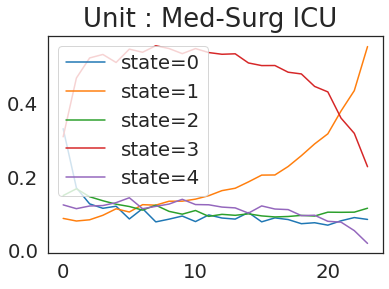

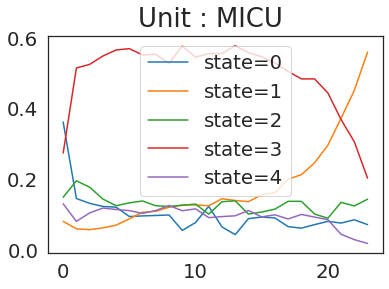

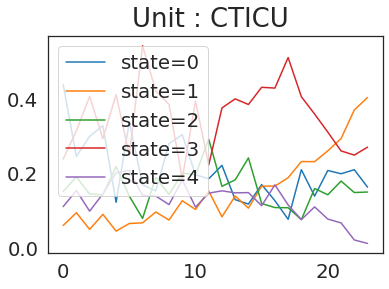

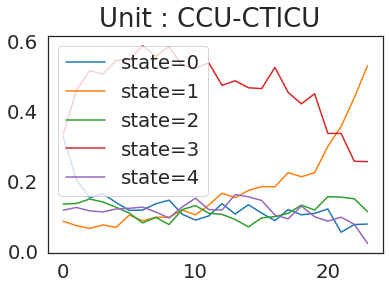

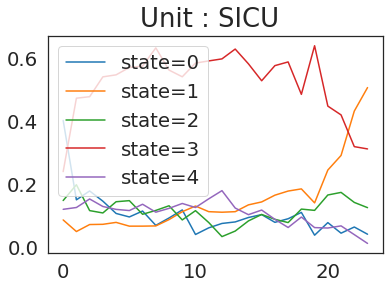

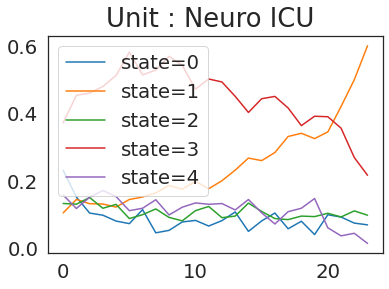

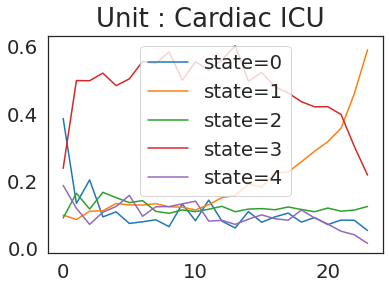

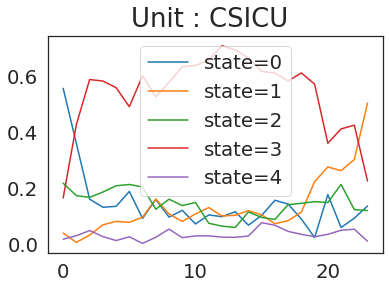

In [68]:
N, T, K = z_test.shape
units = y_test_df['unittype'].unique()
ordinal_label=3
for unit in units:
    f, axs = plt.subplots(1, 1)
    curr_unit_inds = (y_test_df['unittype']==unit)&(y_test_df['los_ordinal_label']==ordinal_label)
    curr_unit_z_test = z_test[curr_unit_inds].mean(axis=0)
    for kk in range(K):
        axs.plot(range(T), curr_unit_z_test[:, kk], 
                 label='state=%s'%kk)
    axs.legend()
    f.suptitle('Unit : %s'%unit)
plt.show()

In [26]:
def plotGauss2DContour(
        mu, Sigma,
        color='b',
        radiusLengths=[1.0, 3.0],
        markersize=3.0,
        ax_handle=None,
        label=''
        ):
    ''' Plot elliptical contours for provided mean mu, covariance Sigma.
    Uses only the first 2 dimensions.
    Post Condition
    --------------
    Plot created on current axes
    '''
    
    # Decompose cov matrix into eigenvalues "lambda[d]" and eigenvectors "U[:,d]"
    lambda_D, U_DD = np.linalg.eig(Sigma)
    
    # Verify orthonormal
    D = len(mu)
    assert np.allclose(np.eye(D), np.dot(U_DD, U_DD.T))
    # View eigenvector matrix as a rotation transformation
    rot_DD = U_DD

    # Prep for plotting elliptical contours
    # by creating grid of G different (x,y) points along perfect circle
    # Recall that a perfect circle is swept by considering all radians between [-pi, +pi]
    unit_circle_radian_step_size=0.03
    t_G = np.arange(-np.pi, np.pi, unit_circle_radian_step_size)
    x_G = np.sin(t_G)
    y_G = np.cos(t_G)
    Zcirc_DG = np.vstack([x_G, y_G])

    # Warp circle into ellipse defined by Sigma's eigenvectors
    # Rescale according to eigenvalues
    Zellipse_DG = np.sqrt(lambda_D)[:,np.newaxis] * Zcirc_DG
    # Rotate according to eigenvectors
    Zrotellipse_DG = np.dot(rot_DD, Zellipse_DG)

#     radius_lengths=[0.3, 0.6, 0.9, 1.2]
    radius_lengths=[1.0, 2.0, 3.0]

    # Plot contour lines across several radius lengths
    for r in radius_lengths:
        Z_DG = r * Zrotellipse_DG + mu[:, np.newaxis]
        ax_handle.plot(
            Z_DG[0], Z_DG[1], '.-',
            color=color,
            markersize=3.0,
            markerfacecolor=color,
            markeredgecolor=color, 
            label=label)
        
    return ax_handle

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), 
#               fontsize=fontsize,  
#               loc='upper right', 
              bbox_to_anchor=(0.99, 1.05)
#               bbox_to_anchor=(0.1, 0.9)
             )
    return ax

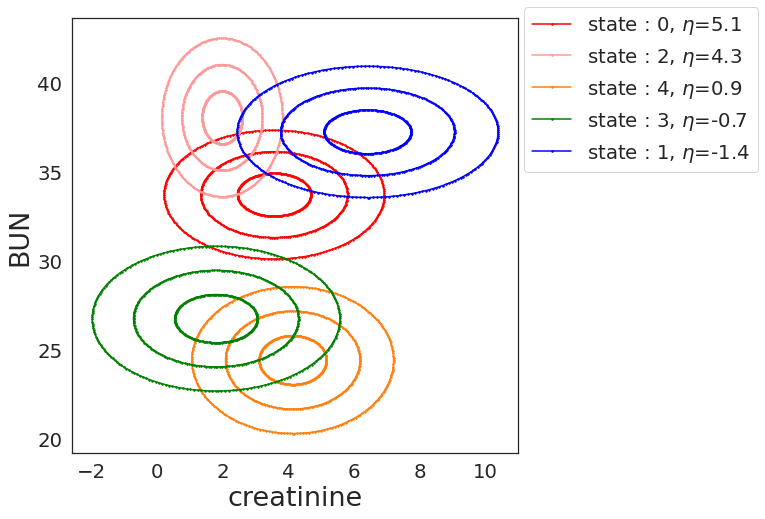

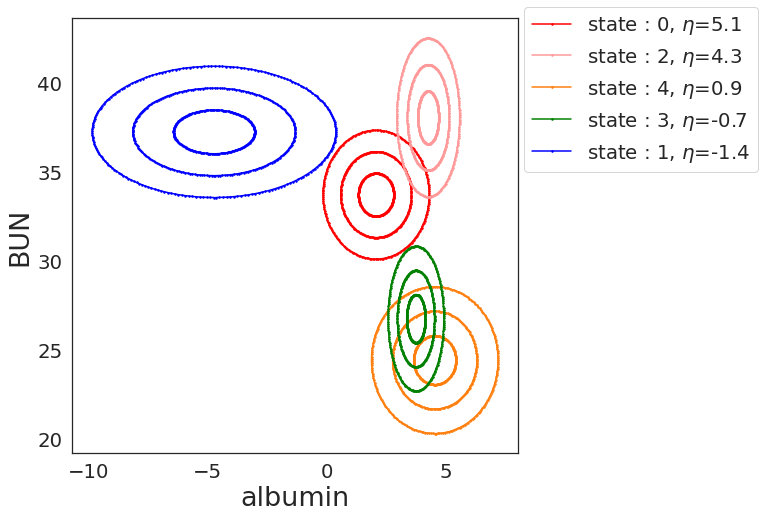

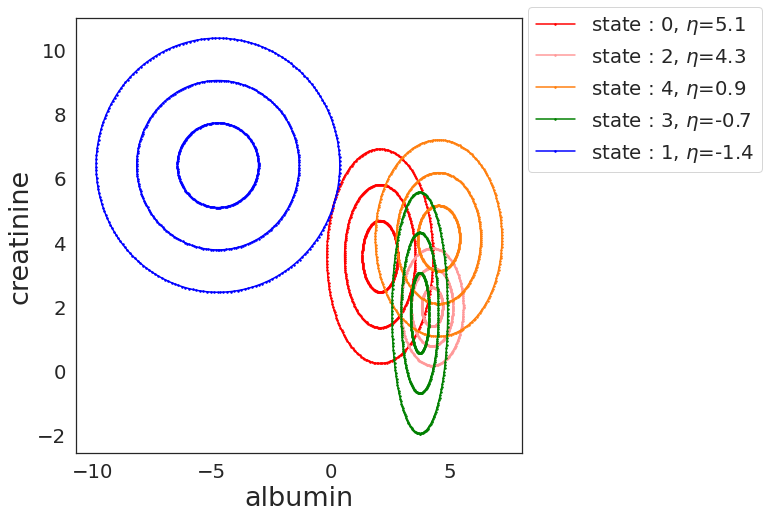

In [39]:
mu_all = model.hmm_model(x_test[:10]).observation_distribution.distribution.mean().numpy()
cov_all = model.hmm_model(x_test[:10]).observation_distribution.distribution.scale.numpy()
predictor_weights_K = np.squeeze(model._predictor.get_weights()[0])
sorted_inds = np.argsort(np.squeeze(model._predictor.get_weights()[0]))[::-1] #np.array([4, 0, 3])
predictor_weights_K_sorted = predictor_weights_K[sorted_inds]

# sorted_inds = np.array([0, 3, 1, 2, 4])
# state_names = ['risk', 'normal']

# state_aka = ['risk state', 'normal state']
keep_features_cols = ['BUN', #'BUN'
                      'creatinine', 
#                       'Hgb', 
                     'albumin'
                     ]

# keep_features_inds = np.where(np.isin(feature_cols, keep_features_cols))


keep_features_inds = [feature_cols.index(ii) for ii in keep_features_cols]
n_influential = len(sorted_inds) # number of influential states to retain from predictor
mu_KD_influential = np.squeeze(mu_all[sorted_inds[:n_influential], :][:, keep_features_inds])
cov_KD_influential = np.squeeze(cov_all[sorted_inds[:n_influential], :][:, keep_features_inds])
feature_cols_reindexed = np.array(feature_cols)[keep_features_inds[0]]

state_colors = ['r', '#FF9999', 'tab:orange', 'g', 'b']
# cohort_names = ['z=4 (Risk state)', 'z=0 (Risk state)', 'z=3 (Normal)']
for combo in combinations(keep_features_cols, 2):
    f, axs = plt.subplots(1, 1, figsize=(8, 8))
    sns.set_style("white") # or use "white" if we don't want grid lines
    sns.set_context("notebook", font_scale=1.8)
    curr_feature_combo_inds = np.isin(keep_features_cols, combo)
    curr_feature_combo = np.array(keep_features_cols)[curr_feature_combo_inds]
    for pp, kk in enumerate(range(n_influential)):
        mu = mu_KD_influential[kk, curr_feature_combo_inds][::-1]
        Sigma = np.diag(cov_KD_influential[kk, curr_feature_combo_inds][::-1])
        axs = plotGauss2DContour(mu, Sigma, ax_handle=axs, 
                         label=r'state : %s, $\eta$=%.1f'%(sorted_inds[kk], 
                                                           predictor_weights_K_sorted[kk]), 
                         color=state_colors[kk]
                        )
        
#         if pp<2:
#             axs = plotGauss2DContour(mu, Sigma, ax_handle=axs, 
#                                      label=r'%s state, $\eta$=%.2f'%(state_names[kk], 
#                                                                       model._predictor.get_weights()[0][sorted_inds[kk]]), 
#                                      color=state_colors[sorted_inds[kk]]
#                                     )
#         else:
#             axs = plotGauss2DContour(mu, Sigma, ax_handle=axs, 
#                                      color=state_colors[sorted_inds[kk]]
#                                     )            
        

    axs.legend()
    axs = legend_without_duplicate_labels(axs, 
#                                           fontsize=45
                                         )
    
    axs.set_xlabel(curr_feature_combo[1], fontsize=27)
    axs.set_ylabel(curr_feature_combo[0], fontsize=27)
    f.savefig('interpretability_%s_%s_EICU.pdf'%(curr_feature_combo[0], 
                                                 curr_feature_combo[1]), 
              bbox_inches='tight', 
              pad_inches=0)

## Plot average belief in each state for los label=0, 1, 2, 3

In [9]:
import numpy as np

def compute_normalized_histogram(data, bins, minx_area=0.0):
    # Compute the histogram
    hist, bin_edges = np.histogram(data, bins=bins)

    # Normalize the histogram
    hist_normalized = hist / np.sum(hist)

    # Compute the area under the histogram
    
    keep_inds = bin_edges>=minx_area
    bin_width = bin_edges[keep_inds][1] - bin_edges[keep_inds][0]
    area_under_histogram = np.sum(hist_normalized[keep_inds[1:]]) * bin_width

    return hist_normalized, bin_edges, area_under_histogram


## Plot histogram of avg beliefs for each LOS category

LOS prediction for <=3
risk state : frac adms with avg belief > 0.10 = 0.1280
LOS prediction for <=3
normal state : frac adms with avg belief > 0.10 = 0.8030
LOS prediction for >3
risk state : frac adms with avg belief > 0.10 = 0.2074
LOS prediction for >3
normal state : frac adms with avg belief > 0.10 = 0.8396
LOS prediction for >5
risk state : frac adms with avg belief > 0.10 = 0.2817
LOS prediction for >5
normal state : frac adms with avg belief > 0.10 = 0.8571
LOS prediction for >7
risk state : frac adms with avg belief > 0.10 = 0.3661
LOS prediction for >7
normal state : frac adms with avg belief > 0.10 = 0.8540


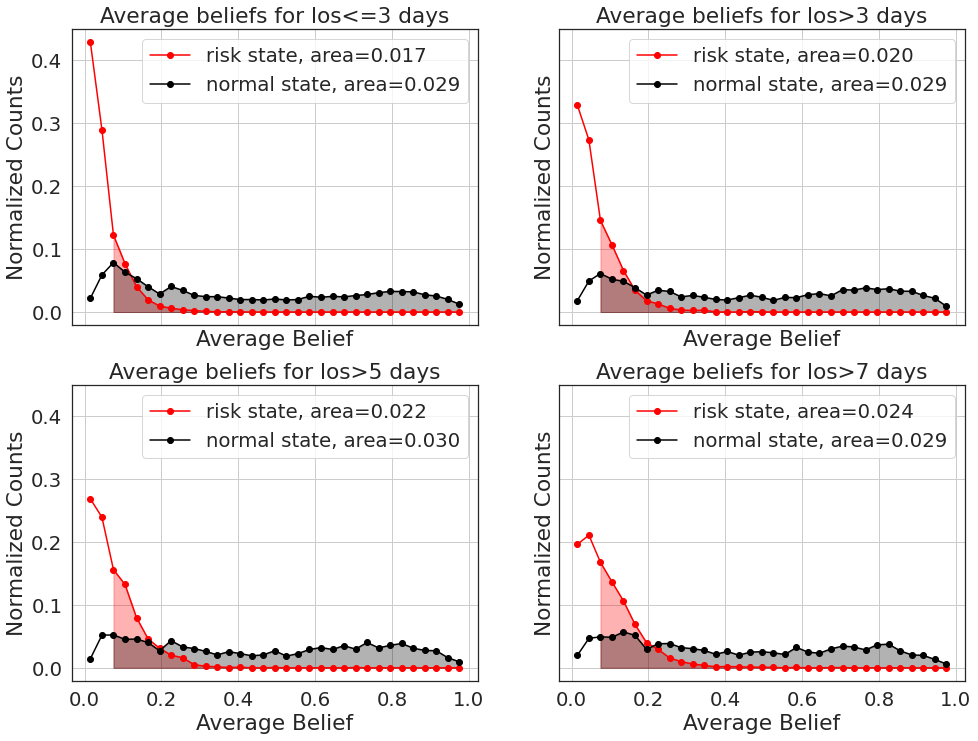

In [132]:
N, T, K = z_test.shape
bins = np.arange(0, 1, 0.05)
min_los_list = ['<=3', '>3', '>5', '>7']
f, axs = plt.subplots(2, 2, 
                      figsize=(16, 12),
                      sharey=True,
                      sharex=True
                     )
axs_list = axs.flatten()


bins=np.arange(0, 1, 0.03)

for ordinal_label in range(4):
    
    curr_inds = y_test_df['los_ordinal_label']==ordinal_label
    curr_label_z_test_NTK = z_test[curr_inds]
    curr_label_avg_belief_NK = np.mean(curr_label_z_test_NTK, axis=1)
    minx_area = 0.05
    for pp, kk in enumerate([0, 3]):
        hist_normalized, bin_edges, area_under_histogram = compute_normalized_histogram(curr_label_avg_belief_NK[:, kk], 
                                                                                        bins, minx_area=minx_area)
        bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
        axs_list[ordinal_label].plot(bin_centers, hist_normalized, marker='o', linestyle='-', 
                                     label='%s state, area=%.3f'%(state_names[pp], area_under_histogram), 
                                     color=state_colors[kk])
#         axs_list[ordinal_label].set_xlabel('Bins')
        axs_list[ordinal_label].set_ylabel('Normalized Counts')
        axs_list[ordinal_label].set_title('Normalized Histogram')
        axs_list[ordinal_label].grid(True)
        
        # Shade the area under the line plot for x > minx_area
        mask = bin_centers > minx_area
        axs_list[ordinal_label].fill_between(bin_centers[mask], 0, hist_normalized[mask],
                                             alpha=0.3, color=state_colors[kk])
        print('=========================')
        print('LOS prediction for %s'%min_los_list[ordinal_label])
        
        min_belief=0.1
        curr_N = curr_label_avg_belief_NK.shape[0]
        frac_n_high_beliefs = (curr_label_avg_belief_NK[:, kk]>=min_belief).sum()/curr_N
        print('%s state : frac adms with avg belief > %.2f = %.4f'%(state_names[pp], min_belief, frac_n_high_beliefs))
        
        
        
    axs_list[ordinal_label].legend()
    axs_list[ordinal_label].set_xlabel('Average Belief')
    axs_list[ordinal_label].set_title('Average beliefs for los%s days'%min_los_list[ordinal_label])
# f.savefig('avg_beliefs_distributions_for_various_los.png', bbox_inches='tight', pad_inches=0)
plt.show()

## plot the fraction of patients in the risk state with avg belief > X

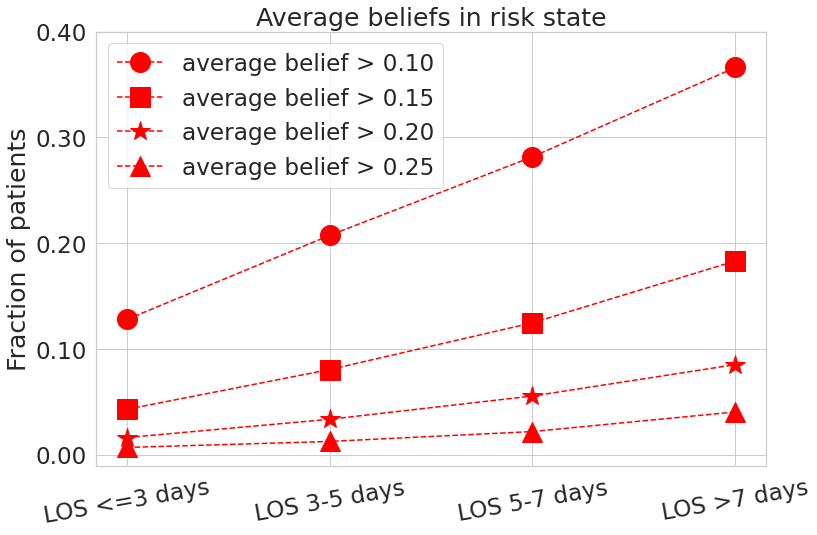

In [18]:
N, T, K = z_test.shape
bins = np.arange(0, 1, 0.05)
min_los_list = ['LOS <=3 days', 'LOS 3-5 days', 'LOS 5-7 days', 'LOS >7 days']
f, axs = plt.subplots(1, 1, 
                      figsize=(12, 8),
                     )
sns.set_style("whitegrid") # or use "white" if we don't want grid lines
sns.set_context("notebook", font_scale=2.1)
perf_dict_list = []
min_belief_list = [0.1, 0.15, 0.2, 0.25]
for ordinal_label in range(4):
    for min_belief in min_belief_list:
    
        curr_inds = y_test_df['los_ordinal_label']==ordinal_label
        curr_label_z_test_NTK = z_test[curr_inds]
        curr_label_avg_belief_NK = np.mean(curr_label_z_test_NTK, axis=1)
        minx_area = 0.05
        for pp, kk in enumerate([0, 3]):

            # Shade the area under the line plot for x > minx_area
#             print('=========================')
            curr_N = curr_label_avg_belief_NK.shape[0]
#             print('LOS prediction for %s, total adms : %d'%(min_los_list[ordinal_label], curr_N))

            frac_n_high_beliefs = (curr_label_avg_belief_NK[:, kk]>=min_belief).sum()/curr_N
#             print('%s state : frac adms with avg belief > %.2f = %.4f'%(state_names[pp], min_belief, frac_n_high_beliefs))

            perf_dict_list.append({'state' : state_names[pp],
                                  'min_belief' : min_belief,
                                  'frac_n_high_beliefs' : frac_n_high_beliefs,
                                  'los_category' : min_los_list[ordinal_label]})

beliefs_perf_df = pd.DataFrame(perf_dict_list)

marker_list = ['o', 's', '*', '^']
for jj, min_belief in enumerate(min_belief_list):
    curr_inds = (beliefs_perf_df.state=='risk')&(beliefs_perf_df.min_belief==min_belief)
    risk_state_avg_beliefs_per_los = beliefs_perf_df.loc[curr_inds, 'frac_n_high_beliefs'].values
    axs.plot(risk_state_avg_beliefs_per_los, marker=marker_list[jj], linestyle='--', 
             color='r', markersize=20, label='average belief > %.2f'%min_belief)
    axs.set_xticks(np.arange(0, 4))
    axs.set_xticklabels(beliefs_perf_df.loc[curr_inds, 'los_category'].values, rotation=10)
    axs.set_title('Average beliefs in risk state')
#     axs.set_yscale('log')
    axs.set_ylabel('Fraction of patients')
    yticks = np.arange(0, .5, 0.1)
    axs.set_yticks(yticks)
    axs.set_yticklabels(['%.2f'%rr for rr in yticks])
#     axs.set_ylim([-.4, 1])
axs.legend()
plt.show()
f.savefig('avg_beliefs_plots_for_various_los.pdf', bbox_inches='tight', pad_inches=0)
# plt.show()